In [3]:
!git clone https://github.com/Gerardo-cursos/objetos_salon.git

Cloning into 'objetos_salon'...
remote: Enumerating objects: 2507, done.
remote: Counting objects: 100% (655/655), done.
remote: Compressing objects: 100% (507/507), done.
remote: Total 2507 (delta 197), reused 375 (delta 147), pack-reused 1852 (from 5)
Receiving objects: 100% (2507/2507), 1.24 GiB | 29.39 MiB/s, done.
Resolving deltas: 100% (459/459), done.
Updating files: 100% (1764/1764), done.


In [4]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def preprocesarImagenes(root_dir):

    image_data = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    print(class_names)
    class_map = {class_name: i for i, class_name in enumerate(class_names)}
    target_size = (128, 128)
    for class_name in class_names:
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for filename in os.listdir(class_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_dir, filename)
                    try:
                        img = Image.open(img_path).convert('RGB')
                        img = img.resize(target_size)
                        img_array = np.array(img) / 255.0  # Normalizar vector de pixeles
                        image_data.append(img_array)
                        labels.append(class_map[class_name])
                    except Exception as e:
                        print(f"error {img_path}: {e}")

    return np.array(image_data), np.array(labels)


In [5]:
root_directory = "/content/objetos_salon/processed"
#procesamos el directorio processed, y gursdamos todo en la variable image_data
image_data, labels = preprocesarImagenes(root_directory)

['README.md', 'cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']


## Creando el autoencoder


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class SimpleAutoencoder(Model):
    def __init__(self, latent_dimensions):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dimensions, activation='relu'),
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(32 * 32 * 64, activation='relu'),
            layers.Reshape((32, 32, 64)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same') # Output channels match input
        ])

    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded


img_dim = 128

autoencoder = SimpleAutoencoder(img_dim)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.summary()

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

## Train the autoencoder

### Subtask:
Train the autoencoder on the image dataset. The goal is to minimize the reconstruction error between the input images and their reconstructed outputs.

In [ ]:
# Train the autoencoder
# Using image_data as both input and target for autoencoder training
autoencoder.fit(image_data, image_data,
                epochs=10,
                batch_size=32,
                shuffle=True,
                validation_split=0.2) # Using a validation split to monitor training

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 107s 3s/step - loss: 0.0659 - val_loss: 0.0478
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - loss: 0.0396 - val_loss: 0.0363
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - loss: 0.0275 - val_loss: 0.0319
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - loss: 0.0217 - val_loss: 0.0288
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - loss: 0.0186 - val_loss: 0.0272
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - loss: 0.0160 - val_loss: 0.0263
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - loss: 0.0145 - val_loss: 0.0262
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - loss: 0.0137 - val_loss: 0.0257
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - loss: 0.0125 - val_loss: 0.0255
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 0.0115 - val_loss: 0.0254


In [ ]:
# predecir el modelo creado con los datos de entrenamiento
image_features = autoencoder.predict(image_data)

n_samples, height, width, channels = image_features.shape
image_features_flattened = image_features.reshape(n_samples, height * width * channels)

print("Shape of extracted features:", image_features_flattened.shape)

51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 633ms/step
Shape of extracted features: (1619, 49152)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Dividir los datos redimensionados en test y train
X_train, X_test, y_train, y_test = train_test_split(image_features_flattened, labels, test_size=0.2, random_state=42)

# usar un clasificador SVC (Support Vector Classifier)
classifier = SVC(gamma='auto')
classifier.fit(X_train, y_train)

SVC(gamma='auto')

In [ ]:
# predecir con los datos de prueba
y_pred = classifier.predict(X_test)

# Metricas de rendimiento
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.72      0.70      0.71        44
           2       0.76      0.82      0.79        65
           3       0.83      0.73      0.78        55
           4       0.62      0.88      0.73        26
           5       0.89      0.73      0.80        45
           6       0.72      0.69      0.70        48
           7       0.63      0.66      0.64        41

    accuracy                           0.74       324
   macro avg       0.74      0.74      0.74       324
weighted avg       0.75      0.74      0.74       324



## Matriz de confusion

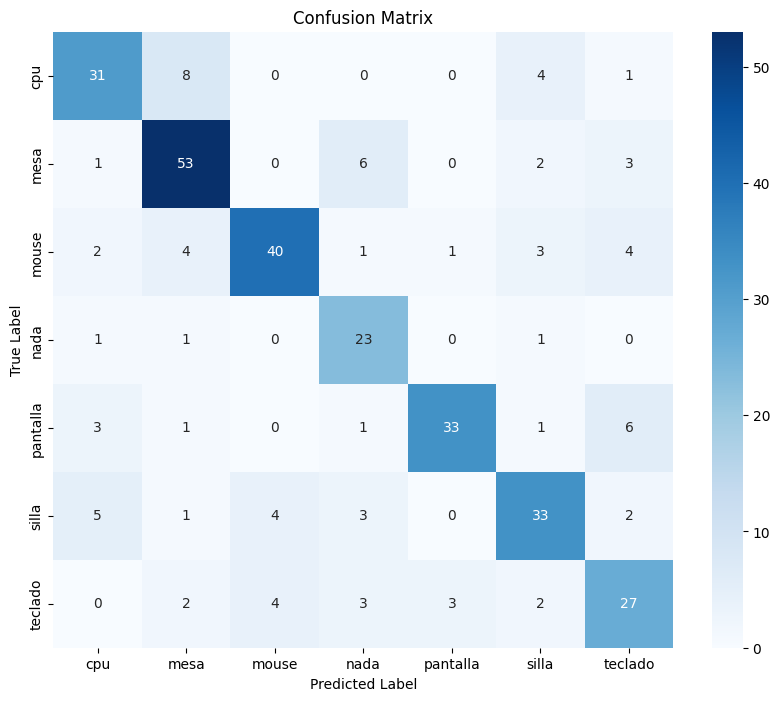

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# matriz de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

class_names = ['cpu', 'mesa', 'mouse', 'nada', 'pantalla', 'silla', 'teclado']


# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [1]:
# Save the autoencoder model in .h5 format
autoencoder.save('autoencoder_model.h5')
print("Model saved successfully as autoencoder_model.h5")

NameError: name 'autoencoder' is not defined